**1. Download Data, model and Preprocessing**

Cần thay đổi chỗ này thành download video của BTC (hiện tại đang là video test của nhóm)

In [ ]:
!pip install gdown

In [ ]:
!gdown --id '1nnCAtnAdSBAyw22JJVqArZHApBfW5vvo'
!unzip 'round2_test.zip'

Download model YOLOv8 to preprocessing

In [ ]:
! gdown --id '10W9QgmQM35Q4BK_T8LTsp3Gn3spVHqqM'

Install lib for yolov8 Preprocessing


In [ ]:
!pip install ultralytics

In [4]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('best.pt')

def process_yolov8(source_image_path):
    results = model.predict(source_image_path, save=False, imgsz=640, conf=0.25, verbose=False)
    for result in results:
        boxes = result.boxes

    im0 = cv2.imread(source_image_path)
    max_area = 0
    largest_cropped_image = im0
    h, w = 0, 0
    for bbox in boxes.xyxy:
        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        if area > max_area:
            max_area = area
            # Adjust the bounding box coordinates to add a 20px margin
            x1, y1, x2, y2 = bbox
            w = int(x2) - int(x1)
            h = int(y2) - int(y1)
            largest_cropped_image = im0[int(y1):int(y2), int(x1):int(x2)]
    return largest_cropped_image

In [5]:
import cv2
from tqdm import tqdm
import os

def process_video(input_video_path, output_video_path):
    # Khởi tạo đối tượng VideoCapture
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Lấy tổng số frames và FPS của video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / original_fps
    # Tính toán phần trăm và thời điểm bắt đầu, kết thúc để cắt
    if duration > 110:
        start_percent = 20
        end_percent = 80
    elif duration > 60:
        start_percent = 15
        end_percent = 85
    elif duration > 10:
        start_percent = 10
        end_percent = 90
    else:
        start_percent = 0
        end_percent = 100

    start_frame = int((start_percent / 100) * total_frames)
    end_frame = int((end_percent / 100) * total_frames)

    # Lấy kích thước frame của video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Tạo đối tượng VideoWriter với FPS là desired_fps
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, original_fps, (224, 224))

    # Đọc từng frame và ghi frame vào video mới nếu nằm trong khoảng đã tính và theo tỷ lệ FPS mới
    current_frame = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Chỉ xử lý frame nếu nằm trong khoảng thời gian đã định
        if start_frame <= current_frame <= end_frame:
            cv2.imwrite('yolo_process.jpg', frame)
            frame = process_yolov8('yolo_process.jpg')
            frame = cv2.resize(frame, (224, 224))
            out.write(frame)

        current_frame += 1

    # Giải phóng tài nguyên
    cap.release()
    out.release()

    print("Video đã được xử lý và lưu tại: ", output_video_path)

Sửa lại đường dẫn video test của BTC

In [8]:
from IPython.display import clear_output
import os
data_dir = "./content/drive/MyDrive/AI4LIFE2024-DATA/Test - Vòng loại"
output_dir = "./data_test_aug_yolo-ed"
os.makedirs(output_dir, exist_ok=True)
i = 0
for video_file in tqdm(os.listdir(data_dir)):
    print('\n')
    if not video_file.startswith('.'):  # Bỏ qua các tệp ẩn
        input_video_path = os.path.join(data_dir, video_file)
        video_name = video_file.split('.')[0]
        output_video_path = os.path.join(output_dir, f"{video_name}.mp4")  # Thay đổi đường dẫn đầu ra

        # Kiểm tra xem video đã tồn tại trong thư mục đầu ra hay không
        if not os.path.exists(output_video_path):
            print(f"Processing {input_video_path}")
            process_video(input_video_path, output_video_path)
        else:
            print(f"Video {output_video_path} đã được xử lý trước đó và tồn tại trong thư mục đầu ra.")
    # Nhớ comment, vì chỉ dùng để debug
    i+=1
    if i==10:
        break
    clear_output()

 23%|██▎       | 9/39 [04:57<25:23, 50.77s/it]



Processing ./content/drive/MyDrive/AI4LIFE2024-DATA/Test - Vòng loại/plank_1.mp4


 23%|██▎       | 9/39 [05:05<16:57, 33.93s/it]

Video đã được xử lý và lưu tại:  ./data_test_aug_yolo-ed/plank_1.mp4


Test video

**2. PROCESSING**, nếu có yêu cầu cần restart thì phải chạy hết cell đó (hoặc gặp thông báo lỗi) rồi restart và tiếp tục chạy tiếp (không cần chạy lại từ trên xuống)

In [ ]:
! pip install datasets
! pip install -q transformers evaluate
! pip install pytorchvideo
! pip install torchvision==0.14.1

In [ ]:
import os
os._exit(00)

Tên các folder lúc train chúng tôi khác với BTC nên inference tôi cũng để tên folder như vậy, chúng tôi sẽ có bước chuẩn hóa trước khi ghi vào file csv

In [1]:
import os

# Root directory name
root_dir = "Workout_Exercises"

# List of exercises - directory names
exercises = [
    "barbell biceps curl", "bench press", "chest fly machine", "dbp",
    "deadlift", "hammer curl", "hip thrust", "incline bench press",
    "lat pulldown", "lateral raise", "leg extension", "leg raises",
    "plank", "pull up", "push-up", "romanian deadlift", "russian twist",
    "shoulder press", "squat", "t bar row", "tricep dips", "tricep pushdown"
]

# Create root directory
os.makedirs(root_dir, exist_ok=True)

# Create each exercise directory within the root directory
for exercise in exercises:
    os.makedirs(os.path.join(root_dir, exercise), exist_ok=True)

"Directories created successfully."

'Directories created successfully.'

Vì code hiện tại chỉ xử lý được số video > = số class, nên tôi sẽ thêm video bổ sung nếu thiếu (video này không xuất ra csv)

In [2]:
!gdown --id '12myvrR4hpmk_V-LCbGO_JRRaoL6hento'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12myvrR4hpmk_V-LCbGO_JRRaoL6hento
To: /content/bonus.mp4
100% 107k/107k [00:00<00:00, 4.82MB/s]


In [ ]:
pwd

'/content'

In [ ]:
import os
import shutil

# Đường dẫn đến thư mục chứa video và thư mục đích
source_dir = './data_test_aug_yolo-ed'
destination_dir = './Workout_Exercises'

# Lấy danh sách tất cả các video trong thư mục nguồn
videos = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# Lấy danh sách tất cả các thư mục con trong thư mục đích
subdirectories = [d for d in os.listdir(destination_dir) if os.path.isdir(os.path.join(destination_dir, d))]

for i, video in enumerate(videos):
      destination_subdir = os.path.join(destination_dir, subdirectories[i % len(subdirectories)])
      source_video_path = os.path.join(source_dir, video)
      destination_video_path = os.path.join(destination_subdir, video)
      shutil.move(source_video_path, destination_video_path)
      print(f'Moved "{video}" to "{destination_subdir}"')
if len(videos) < len(subdirectories):
      for sub in subdirectories:
          full_sub_dir = f"{destination_dir}/{sub}"
          if len(os.listdir(full_sub_dir)) == 0:
              bonus_path = os.path.join(full_sub_dir, 'bonus.mp4')
              shutil.copy('./bonus.mp4', bonus_path)
              # Đổi tên file bonus sau khi sao chép
              new_bonus_name = f"bonus{sub}.mp4"
              new_bonus_path = os.path.join(full_sub_dir, new_bonus_name)
              os.rename(bonus_path, new_bonus_path)
              print(f'Renamed "bonus.mp4" to "{new_bonus_name}" in "{full_sub_dir}"')

Không cần thay đổi đường dẫn dataset_root nếu chạy trên google colab

In [4]:
import os

# Define the root directory of your dataset
dataset_root = './Workout_Exercises'

# Initialize an empty list to store the paths of all video files
all_video_file_paths = []

# Walk through the directory structure
for root, dirs, files in os.walk(dataset_root):
    for file in files:
        # Check if the file is a video file by its extension (assuming .mp4)
        if 1:
            # Construct the full path of the file
            full_path = os.path.join(root, file)
            # Append the full path to the list
            all_video_file_paths.append(full_path)
print(all_video_file_paths)

['./Workout_Exercises/tricep pushdown/chest fly machine_3.mp4', './Workout_Exercises/plank/hip thrush_1.mp4', './Workout_Exercises/push-up/decline bench press_2.mp4', './Workout_Exercises/dbp/t bat row_1.mp4', './Workout_Exercises/hip thrust/push-up_1.mp4', './Workout_Exercises/squat/squat_2.mp4', './Workout_Exercises/pull up/hip thrust_1.mp4', './Workout_Exercises/russian twist/lat pulldown_2.mp4', './Workout_Exercises/chest fly machine/deadlift_1.mp4', './Workout_Exercises/romanian deadlift/plank_1.mp4', './Workout_Exercises/leg raises/bonusleg raises.mp4', './Workout_Exercises/t bar row/bonust bar row.mp4', './Workout_Exercises/incline bench press/bonusincline bench press.mp4', './Workout_Exercises/hammer curl/bonushammer curl.mp4', './Workout_Exercises/lat pulldown/bonuslat pulldown.mp4', './Workout_Exercises/bench press/bonusbench press.mp4', './Workout_Exercises/lateral raise/bonuslateral raise.mp4', './Workout_Exercises/leg extension/bonusleg extension.mp4', './Workout_Exercises

In [5]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['barbell biceps curl', 'bench press', 'chest fly machine', 'dbp', 'deadlift', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raise', 'leg extension', 'leg raises', 'plank', 'pull up', 'push-up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown'].


In [6]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    RandomAffine,
    ColorJitter
)

Load model được lưu ở Hugging Face

In [7]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "bluebird089/videomae-base-finetuned-kinetics-finetuned-round2-v4"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

In [8]:
#mean = image_processor.image_mean
#std = image_processor.image_std

#num_frames_to_sample = model.config.num_frames

#clip_duration = 3

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [9]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((224,224)),
                ]
            ),
        ),
    ]
)

import shutil
checkpoints_path = '/content/Workout_Exercises/.ipynb_checkpoints'
shutil.rmtree(checkpoints_path, ignore_errors=True)

# Now, you can load your dataset as before
test_dataset = pytorchvideo.data.Ucf101(
    data_path='/content/Workout_Exercises',
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [10]:
print(test_dataset.num_videos)

22


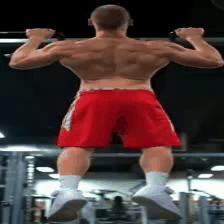

In [11]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 5}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(test_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

**3. Hậu xử lý** vì mô hình chúng tôi chia nhỏ video đầu vào thành các video có thời lượng ngắn nên cần biết sau khi tách nhỏ video nhỏ thuộc video lớn nào, predicted sẽ là số lần xuất hiện nhiều nhất

In [12]:
videos = []
labels = []
video_names = []
for sample in test_dataset:
    video_tensor = sample["video"]
    video_label = id2label[sample["label"]]
    video_name = sample["video_name"]
    videos.append(video_tensor)
    labels.append(video_label)
    video_names.append(video_name)


In [13]:
import torch
def run_inference(model, video, label):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        # "labels": torch.tensor(
        #     [label]
        # ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [14]:
predicted = []
for index in range(len(videos)):
  logits = run_inference(model, videos[index], labels[index])
  predicted_class_idx = logits.argmax(-1).item()
  predicted.append(model.config.id2label[predicted_class_idx])

In [15]:
# Chuyển đổi list thành set để loại bỏ các phần tử trùng lặp
S = set(video_names)

print(S.__len__())

22


Print thử kết quả, trước khi ghi vào file CSV chúng tôi cần chuẩn hóa tên 1 vài class để đảm bảo giống BTC

In [16]:
def changeName(label):
  if label == 'dbp':
    return 'decline bench press'
  elif label == 'tricep pushdown':
    return 'tricep Pushdown'
  elif label == 'pull up':
    return 'pull Up'
  else:
    return label

Vui lòng sửa ***data_dir*** là thư mục chứa video test của BTC

In [17]:
import os

data_dir = "/content/content/drive/MyDrive/AI4LIFE2024-DATA/Test - Vòng loại"

def getVideoName(videoName):
  base_name = videoName.split('.')[0]
  for name in os.listdir(data_dir):
        if name.split('.')[0] == base_name:
              return name
  return 'Error'

Lưu kết quả vào file result.csv

In [18]:
from collections import Counter
import csv
# List để lưu các id (vị trí) của phần tử từ S trong L
indices = []

filename = "result.csv"
with open(filename, 'w', newline='') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(['video', 'Dự đoán'])
  for item in S:
    if 'bonus' not in item:
      try:
          # print(item)
          # Lặp qua từng phần tử của S và tìm id của nó trong L
          # Lưu ý: Vòng lặp dưới đây sẽ tìm tất cả các vị trí của item trong L
          indices = [i for i, x in enumerate(video_names) if x == item]
          # print(indices)
          values = [predicted[i] for i in indices]

          # Sử dụng Counter để thống kê và tìm giá trị xuất hiện nhiều nhất
          most_common_value, count = Counter(values).most_common(1)[0]

          # print(f'Giá trị xuất hiện nhiều nhất là: {most_common_value} với {count}/{indices.__len__()} lần xuất hiện - label {item}')
          value = changeName(most_common_value)
          videoName = getVideoName(item)
          csvwriter.writerow([videoName, value])
          indices = []
      except ValueError:
          # Nếu phần tử không tồn tại trong L, bỏ qua
          continue